# Pix2Pix with Tensorflow 2.0 and Kubeflow Pipelines


Goals, Acknowledgments and Cluster Setup : see [project's README](./README.md#) and [Setup instructions](./SETUP.md).

## Overview

**In this Kubeflow example, you will build a Kubeflow pipeline to train a Deep Learning model named Pix2Pix**, which is a Conditional Adversarial Network. You can learn more on Pix2Pix by visiting its [official Project Homepage](https://github.com/phillipi/pix2pix)  or the [Pix2Pix Tensorflow 2.0 tutorial](https://www.tensorflow.org/beta/tutorials/generative/pix2pix).

In practical terms, the Pix2Pix model allows to "translate" a source image into a target image like in this example:


![Pix2Pix results example](doc-assets/results.png "Pix2Pix results example")


**The Kubeflow Pipeline you are going to build in this notebook will be composed of 4 tasks, assembled in a pipeline workflow:**

- **Download Dataset**: This task will handle the retrival of the Facade dataset archive, and uncompress the dataset images 

- **Prepare Dataset**: This task will transform the training and test jpeg images from the Facade dataset into a training and a test TFRecords files (TFrecords is an effecient way to serialize and store/read data in Tensorflow)

- **Train Pix2Pix**: This task will build and train a Pix2Pix Deep Learning model, using the TFRecords training dataset file.

- **Test Pix2Pix**: This task will use the trained model to translate the images of the test dataset (also provided in a TFrecords file)


![Pix2Pix Kubeflow Pipeline](doc-assets/pipeline.png "Pix2Pix Kubeflow Pipeline")


## Set your GCP Project ID

As this example is designed for being executed with Kubeflow on GKE, the code will makes use of [Google Cloud Build](https://cloud.google.com/cloud-build/) to build the Docker images (The built images will be hosted on some Google Storage linked to your Project's account, and that will also act as a Docker registry).

In [1]:
# -------------------------------------
#           IMPORTANT :
#      Customize this variable with
#        your own GCP Project ID
#
#      (it is used to build and
#       access Docker images)
# -------------------------------------

GCP_PROJECT_ID=None

assert (GCP_PROJECT_ID) != None, "Your must set your own GCP Project ID"


**Remark to save some time:** 

If you have previously executed the Preparation steps, and that you are restarting for example your Jupyter Notebook Kernel, you can skip the Preparation section, and just [restart from this notebook's section](#Restart-here).

----------------
## Preparation  (Required only for the 1st execution)

### Install Python libraries

In [ ]:
%%bash 

# -------------------------------------
#     Install required libraries to 
#   later display the generated images
#      in this Jupyter notebook
# -------------------------------------
pip3 install matplotlib Pillow tensorflow==2.0.0-rc0 \
             --disable-pip-version-check --upgrade --quiet 

# -------------------------------------
#   Install Kubeflow Pipelines SDK
#
# This Python library allows to define 
# a pipeline composed of multiple tasks,
# and execute it on a Kubeflow Cluster
# -------------------------------------
pip3 install https://storage.googleapis.com/ml-pipeline/release/0.1.20/kfp.tar.gz \
              --quiet --disable-pip-version-check --upgrade
              

### Create subdirectories in the NFS storage

In [ ]:
%%bash

mkdir -p /mnt/nfs/data/datasets
mkdir -p /mnt/nfs/data/models
mkdir -p /mnt/nfs/data/pix2pix_outputs

# ------------------------------------- 
#  Copy the pre-trained Pix2Pix model
#  on the NFS storage where it can be
#  accessed by running pipelines
# -------------------------------------
cp -R ./pretrained_model /mnt/nfs/data

### Build the Docker Images 

Anticipating some later steps in this example, where you are going to define and execute a Kubeflow pipeline to train a Pix2Pix model, you are going first to build the **Tensorflow template** Docker images that are going to be used.

You will then build ready to use **Kubeflow pipeline components** for the "Download dataset" and "Prepare Dataset" tasks by packaging their corresponding Python functions into some **Docker Images**. 

 - Buidling these Docker containers is rather tedious and unfortunately, it takes a little time to proceed due to the size of the Tensorflow Docker Images. But unless you modify the provided source code, **you should normally have to build these Docker images only once and for all. So in order to save time, feel free to skip this part if already done !**

In order to save time, we will not package the "Train Pix2Pix" and "Test Pix2Pix" tasks in Docker Image. Instead, you will see how you can compile on-the-fly a python function into a Kubeflow pipeline task. This method can be very usefull when prototyping your code for example. And of course, when ready, you can still package the code into a Docker image to get sharable and ready to use **Kubeflow Pipeline components**.

#### Build custom Tensorflow GPU Template Docker image

This images will just be used as "blank template" to later build our Kubeflow Components (that are executed by Kubeflow  inside Docker containers) 

So basically, this is regular Tensorflow 2.0 Docker images where we pre-install the Python libraries that will be used by this Pix2Pix project. 


In [ ]:
%%bash -s "$GCP_PROJECT_ID"

# -------------------------------------
#     Define a Dockerfile, Build a  
#       Docker image template 
#        with Tensorflow GPU
# -------------------------------------
cat > ./Dockerfile <<- "EOF"
FROM tensorflow/tensorflow:2.0.0rc0-gpu-py3
RUN pip install --quiet Pillow matplotlib
EOF

# -------------------------------------
#       Build a Docker Image on GCP 
#         using the gcloud tool
# -------------------------------------
gcloud builds submit --tag gcr.io/$1/kubeflow_gpu_template:latest .

#### Build the Docker image for the "Download Dataset task"


In [ ]:
%%bash -s "$GCP_PROJECT_ID"

# -------------------------------------
#     Define a Dockerfile, Build a  
#       Docker image to package 
#   the Kubeflow Pipelines Operation 
# -------------------------------------
cat > ./Dockerfile <<- "EOF"
FROM tensorflow/tensorflow:2.0.0b1-py3  
ADD ./download_dataset.py /ml/download_dataset.py
WORKDIR /ml
ENTRYPOINT ["python", "/ml/download_dataset.py"]
EOF

# -------------------------------------
#       Build a Docker Image on GCP 
#         using the gcloud tool
# -------------------------------------
gcloud builds submit --tag gcr.io/$1/download_dataset:latest .

#### Build the Docker image for the "Prepare Dataset task"


In [ ]:
%%bash -s "$GCP_PROJECT_ID"

# -------------------------------------
#     Define a Dockerfile, Build a  
#       Docker image to package 
#   the Kubeflow Pipelines Operation 
# -------------------------------------
cat > ./Dockerfile <<- "EOF"
FROM tensorflow/tensorflow:2.0.0b1-py3
RUN pip install --quiet Pillow 
ADD ./prepare_dataset.py /ml/prepare_dataset.py
WORKDIR /ml
ENTRYPOINT ["python", "/ml/prepare_dataset.py"]
EOF

# -------------------------------------
#       Build a Docker Image on GCP 
#         using the gcloud tool
# -------------------------------------
gcloud builds submit --tag gcr.io/$1/prepare_dataset:latest .

#### Not Building the Docker image for the "Train the Pix2Pix model" and "Test the Pix2Pix model" tasks:

As previously explained, we will not build manually Docker Images for these two tasks, but here is what the code would have looked like. Notice, how for these tasks we would have used the **Tensorflow GPU template**.

(Code below is disabled)

```
%%bash -s "$GCP_PROJECT_ID"

# -------------------------------------
#     Define a Dockerfile, Build a  
#       Docker image to package 
#   the Kubeflow Pipelines Operation 
# -------------------------------------

cat > ./Dockerfile <<- "EOF"
FROM tensorflow/tensorflow:2.0.0rc0-gpu-py3
RUN pip install --quiet Pillow matplotlib
ADD ./train_pix2pix.py /ml/train_pix2pix.py
ADD ./model.py /ml/model.py
ADD ./utils.py /ml/utils.py
WORKDIR /ml
ENTRYPOINT ["python", "/ml/train_pix2pix.py"]
EOF

# -------------------------------------
#       Build a Docker Image on GCP 
#         using the gcloud tool
# -------------------------------------
gcloud builds submit --tag gcr.io/$1/train_pix2pix:latest .


# -------------------------------------
#     Define a Dockerfile, Build a  
#       Docker image to package 
#   the Kubeflow Pipelines Operation 
# -------------------------------------

FROM tensorflow/tensorflow:2.0.0rc0-gpu-py3
RUN pip install --quiet Pillow matplotlib
ADD ./test_pix2pix.py /ml/test_pix2pix.py
ADD ./model.py /ml/model.py
ADD ./utils.py /ml/utils.py
WORKDIR /ml
ENTRYPOINT ["python", "/ml/test_pix2pix.py"]
EOF

# -------------------------------------
#       Build a Docker Image on GCP 
#         using the gcloud tool
# -------------------------------------
gcloud builds submit --tag gcr.io/$1/test_pix2pix:latest .

```

## Build and Execute Pix2Pix Kubeflow Pipelines 

#### Restart-here


If you have alaredy executed the previous steps, and that you are restarting your Jupyter Notebook Kernel, you can restart from this cell:

----------------
### Configure the execution environment



In [2]:
# -------------------------------------
#    Notebook configuration 'magic'
# -------------------------------------
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Setup the project

In [3]:
# -------------------------------------
#     Import Kubeflow Pipelines SDK 
# -------------------------------------
import kfp
import kfp.dsl as dsl
import kfp.gcp as gcp
import kfp.notebook
import kfp.components as comp
from kfp import compiler
from kubernetes import client as k8s_client

In [4]:
# -------------------------------------
#    DEFINE SOME PROJECT VARIABLES
# -------------------------------------
URL = "https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz"
FILE_NAME = "facades.tar.gz"

NFS_MOUNT = "/mnt/nfs"
KERAS_CACHE_DIR = "/mnt/nfs/data/"

MODEL = "/mnt/nfs/data/models/"
PRETRAINED_MODEL = "/mnt/nfs/data/pretrained_model/"
PIX2PIX_OUTPUTS = "/mnt/nfs/data/pix2pix_outputs/"
TENSORBOARD_LOGS = 'gs://wl-tex10-kfp-001/tensorboard/{{workflow.name}}'


### (Optional) Verify that the code can still be executed without Kubeflow

One interesting thing about Kubeflow pipelines, is that **the changes required in the python code to be compliant with Kubeflow while remaining usable outside Kubeflow are very minimal**. In fact, as you will see, **it is as easy to prototype interactively the pipeline code than packaging it as Pipeline components for executing production workflows - and thus without rewriting the code.**

The Pix2Pix source code provided in this example can be executed with Kubeflow pipelines (either by converting the python functions into Kubeflow operations on-the-fly, or by packaking the code into Docker images/Kubeflow components as you will do in the next steps), and at the same time, is still usable outside Kubeflow.

Seet how it is done by inspecting the code in the [`download_dataset.py`](./download_dataset.py) file for example. Notice how:

- the Pipeline component's **code is entirely self-contained in a python function**, including the necessary Python imports too
- the **types of the input/output parameters of the python function defining a pipeline components are specified**
- the Output of the Kubeflow pipelines must be written in an `/output.txt`file

(Note: Read more about the comment tags `#KFP-NEST-IMPORT`, `#KFP-NEST-HERE`, `#KFP-BEGIN` and `#KFP-END` used in `model.py`, `util.py`, `train_pix2pix.py` and `test_pix2pix.py` by having a look at the `nestify.sh` script source code)

If you want, execute the below cell code to execute *locally* the download dataset program. You might do similarly for the other tasks.

In [5]:
%%bash 
# -------------------------------------
#             OPTIONAL :  
#      Local Python execution 
#           (No Kubeflow)
# -------------------------------------

python download_dataset.py --fname facades.tar.gz \
    --origin "https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz"


30171136/30168306 [==============================] - 2s 0us/step
Path location to the dataset images is ./datasets/facades
./datasets/facades contains ['val', 'train', 'test']


### Code management tip and tricks used in this project implementation

Usually this is a good idea to define the code of a componnent, like the training Pix2Pix task, in several python files. For example this allows to manage the model definition, and other helper functions separately, and makes possible to share their source code in different components (without duplication) when buidling docker images for Kubeflow.  In this implementation of Pix2Pix, `model.py` and `utils.py` are both used by `training-pix2pix.py` and `test_pix2pix.py`

Now, with Kubeflow Pipelines, by using the SDK's `kfp.components.func_to_container_op()` method , it is possible to convert a Python function into a pipeline component and return a factory function. You can then call the factory function to construct an instance of a pipeline task (ContainerOp) that runs the original function in a container.

This is very usefull to use this method when prototyping the code in Jupyter Notebooks, rather having to wait for building dedicated Docker images at each iterations. However all the necessary code (including the imports) must be self-contained inside that python function.

`nestify.sh` is a little helper shell script provided with this project, and that aims to automate the conversion of the code from a multiple files implementations into a nested single file implementation. This is done by including a few tag comments in that code at the appropriate locations.

Now you have the flexibity to write your pipeline code in multiple files (as regular Python code), while having the possibility to define Kubeflow components using `func_to_container_op`, which requires that all the necessary code (including the imports) are self-contained inside the python function defining the Kubeflow component. With the nestify script (and a couple of comment tags added in the source code), this can be done without having to duplicate/modify your code.

You can read more about how to use this script by looking at its documentation included inside the script.


In [6]:
%%bash 
chmod u+x ./nestify.sh
#./nestify.sh --help

# -------------------------------------
#   Embed program dependencies 
#   inside a copy of train_pix2pix.py
#   and test_pix2pix.py 
# ------------------------------------- 
./nestify.sh train_pix2pix.py
./nestify.sh test_pix2pix.py


Processing train_pix2pix.py:
 Logs are in ./nested_train_pix2pix.py.log 
 Output result is in ./nested_train_pix2pix.py
 Usage : 'import nested_train_pix2pix.py' instead of 'import train_pix2pix.py'

 ~ End of Nestify processing ~


Processing test_pix2pix.py:
 Logs are in ./nested_test_pix2pix.py.log 
 Output result is in ./nested_test_pix2pix.py
 Usage : 'import nested_test_pix2pix.py' instead of 'import test_pix2pix.py'

 ~ End of Nestify processing ~



### Build and execute a Kubeflow Pipeline

First, you will use the `download_dataset:latest`, `prepare_dataset:latest` Docker images previously built. These images, which contain the corresponding pix2pix source code files, are **ready to use Kubeflow Pipeline components**, that you can share and reuse.

Then, you will see how you can build on-the-fly some Kubeflow Pipeline components by directly converting their python code,  without having to manually package their code into Docker images. In order to do so,  the `kubeflow_gpu_template:latest` Docker images previously built will be used.

 - Note : Should you later work a Kubeflow pipeline project on your own, and want to prototype, iterate and test *quickly* your code, without having to wait for building docker images, remember to make sure that all the python libraries you will need are included in the template Docker image you will use.


Notice, in the below code, how the main difference between these 2 methods, is just the use of `kfp.dsl.ContainerOp(...)` instead of `comp.func_to_container_op` methods.


In [7]:
# -------------------------------------
#      Import the  PiX2Pix code
#  (Note that we use the "nested" /
#  self-contained function code version)
# -------------------------------------
from nested_train_pix2pix import *
from nested_test_pix2pix import *

# ------------------------------------- 
# Create Kubeflow Pipelines Operations
#        from Docker Images
# -------------------------------------
def download_op(fname=FILE_NAME, origin=URL, 
                cachedir=KERAS_CACHE_DIR, cachesubdir='datasets'):
    
    return kfp.dsl.ContainerOp(name="Download Dataset",
                               image='gcr.io/{}/download_dataset:latest'.format(GCP_PROJECT_ID),
                               command=['python', '/ml/download_dataset.py'],
                               arguments=['--fname', fname,
                                          '--origin', origin,
                                          '--cachedir', cachedir,
                                          '--cachesubdir', cachesubdir ],
                               file_outputs = {'outputdir': '/output.txt'}
                              )


def prepare_dataset_op(pathimg, pathimgsubdir, op_name):

    return kfp.dsl.ContainerOp(name=op_name,
                               image='gcr.io/{}/prepare_dataset:latest'.format(GCP_PROJECT_ID),
                               command=['python', '/ml/prepare_dataset.py'],
                               arguments=['--pathimg', pathimg,
                                          '--pathimgsubdir', pathimgsubdir ],
                               file_outputs = {'outputdir': '/output.txt'}
                              )


# -------------------------------------
#  Using the Kueflow SDK, build the 
#  pipeline component/ops  for 
#  the "Train Pix2Pix" and "Test Pix2Pix" 
#  tasks by directly converting their 
#  Python function into a KFP ops 
# -------------------------------------

train_op = comp.func_to_container_op(train_pix2pix,
                                     base_image='gcr.io/{}/kubeflow_gpu_template:latest'.format(GCP_PROJECT_ID))

test_op = comp.func_to_container_op(test_pix2pix,
                                    base_image='gcr.io/{}/kubeflow_gpu_template:latest'.format(GCP_PROJECT_ID))




#### Just for information, here is what would the train_op and test_op components would have looked if being built from Docker image

(Below code is disabled)

```
def train_op(pathdataset, pathmodel, pathlogs, epochs, learningrate, batchsize):

    return kfp.dsl.ContainerOp(name="Train Pix2Pix model",
                               image='gcr.io/{}/train_pix2pix:latest'.format(GCP_PROJECT_ID),
                               command=['python', '/ml/train_pix2pix.py'],
                               arguments=['--pathdataset', pathdataset,
                                          '--pathmodel', pathmodel,
                                          '--pathlogs', pathlogs,
                                          '--epochs', epochs,
                                          '--learningrate', learningrate,
                                          '--batchsize', batchsize ],
                               file_outputs = {'outputdir': '/output.txt'}
                              )


def test_op(pathdataset, pathoutput, pathmodel):

    return kfp.dsl.ContainerOp(name="Test Pix2Pix",
                               image='gcr.io/{}/test_pix2pix:latest'.format(GCP_PROJECT_ID),
                               command=['python', '/ml/test_pix2pix.py'],
                               arguments=['--pathdataset', pathdataset,
                                          '--pathoutput', pathoutput,
                                          '--pathmodel', pathmodel ],
                               file_outputs = {'outputdir': '/output.txt'}
                              )
```


#### Execute the code below to **Define the Kubeflow Pipeline** 

The pipeline workflow is defined within this single python function. It may looks a bit verbose at first sight, but don't worry, this is rather simple ! 

In particular, notice:
- how the pipeline is defined within a single Python function (using a ` @dsl.pipeline` decorator)
- how some pipeline parameters are specified for this function (with the `dsl.PipelineParam` function)
- how the output of some task becomes the input  of others, thus defining a **pipeline workflow**
- how the access to the NFS volume storage, managed by the Kubernetes cluster, is granted to these Kubeflow pipelines components 
   - During the execution Kubeflow will launch Docker containers to execute the tasks define in the pipeline workflow. The calls to the `add_volume(...)` and `add_volume_mount(...)` methods allows to grant access to that NFS volume for these running containers.
   - Accessing a NFS volume on the cluster is rather specific to our Pix2Pix project implementation, where we wanted all tasks to access a shared storage. You might not need this in your own Kubeflow projects
- how we specify a task to be executed on a GPU node inside the cluster


In [8]:
# ------------------------------------- 
#  Define the pix2pix Pipeline Function
# -------------------------------------

@dsl.pipeline(name='Prototyping pipeline',
              description='A Pix2Pix pipeline defined on-the-fly' )

def pix2pix(
    
    ## -- Download Dataset Kubeflow Pipeline component parameters (with default values)
    origin = dsl.PipelineParam('origin', value=URL),
    fname = dsl.PipelineParam('fname', value=FILE_NAME),
    cachedir = dsl.PipelineParam('cachedir', value=KERAS_CACHE_DIR), # on Kubeflow GKE/NFS 
    cachesubdir = dsl.PipelineParam('cachesubdir', value="datasets"),
    
    ## -- Prepare Dataset Kubeflow Pipeline component parameters (with default values)
    pathimgsubdirtrain = dsl.PipelineParam('pathimgsubdirtrain', value="train"),
    pathimgsubdirtest = dsl.PipelineParam('pathimgsubdirtest', value="test"),
    
    ## -- Train Pix2Pix Kubeflow Pipeline component parameters (with default values)
    epochs = dsl.PipelineParam('epochs', value="1"),
    learningrate = dsl.PipelineParam('learning rate', value="2e-4"),
    batchsize = dsl.PipelineParam('batch size', value="1"),
    pathmodel = dsl.PipelineParam('pathmodel', value=MODEL),
    pathlogs = dsl.PipelineParam('pathlogs', value=TENSORBOARD_LOGS),
    
    ## -- Test Pix2Pix Kubeflow Pipeline component parameters (with default values)
    pathoutput = dsl.PipelineParam('pathoutput', value=PIX2PIX_OUTPUTS)
):
    
    
    # ----------------------------------------------------------------------------- 
    #  Here starts the pix2pix function body
    #
    #  A pipeline workflow will be assembled by defining tasks, which consist of
    #  calling the Kubeflow operations and passing them some pipeline parameters.
    #
    #  Task's output, becomes other task's input, thus creating a workflow ! 
    #
    # ------------------------------------------------------------------------------
        
    # Note how we are passing pipeline parameters as operation arguments (Returns a dsl.ContainerOp class instance)
    download_task = download_op(fname, origin, cachedir, cachesubdir) \
                                .add_volume(k8s_client.V1Volume(name='workdir', 
                                                                persistent_volume_claim=k8s_client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs'))) \
                                .add_volume_mount(k8s_client.V1VolumeMount(mount_path=NFS_MOUNT, name='workdir'))
    
    
    prepare_train_task = prepare_dataset_op(pathimg=download_task.output, 
                                            pathimgsubdir=pathimgsubdirtrain,
                                            op_name="Prepare Train Dataset") \
                                .add_volume(k8s_client.V1Volume(name='workdir', 
                                                                persistent_volume_claim=k8s_client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs'))) \
                                .add_volume_mount(k8s_client.V1VolumeMount(mount_path=NFS_MOUNT, name='workdir'))
        

    prepare_test_task = prepare_dataset_op(pathimg=download_task.output,
                                           pathimgsubdir=pathimgsubdirtest,
                                           op_name="Prepare test Dataset") \
                                .add_volume(k8s_client.V1Volume(name='workdir', 
                                                                persistent_volume_claim=k8s_client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs'))) \
                                .add_volume_mount(k8s_client.V1VolumeMount(mount_path=NFS_MOUNT, name='workdir'))
    

    train_task = train_op(pathdataset=prepare_train_task.output,
                          pathmodel=pathmodel,
                          pathlogs=pathlogs,
                          epochs=epochs,
                          learningrate=learningrate, 
                          batchsize=batchsize) \
                                .add_volume(k8s_client.V1Volume(name='workdir', 
                                                                persistent_volume_claim=k8s_client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs'))) \
                                .add_volume_mount(k8s_client.V1VolumeMount(mount_path=NFS_MOUNT, name='workdir'))
    
    # Authorize to write the Tensorboard logs on Google Storage
    # (so that they are accessible by the Tensorboard widget in Kubeflow)
    train_task.apply(gcp.use_gcp_secret('user-gcp-sa')) 
    
    # Do the training task on a GPU node
    train_task.set_gpu_limit(1)
    

    test_task = test_op(pathdataset=prepare_test_task.output, 
                        pathoutput=pathoutput,
                        pathmodel=train_task.output) \
                                .add_volume(k8s_client.V1Volume(name='workdir', 
                                                                persistent_volume_claim=k8s_client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs'))) \
                                .add_volume_mount(k8s_client.V1VolumeMount(mount_path=NFS_MOUNT, name='workdir'))
    
    # Do the testing task on a GPU node
    test_task.set_gpu_limit(1)

#### Run the cell below to **Compile the Kubeflow Pipeline** 

The compilation transform the pipeline definition (pipeline definition and pix2pix source code), into a DSL code, that will be compressed in a tar.gz archive, ready to be submited to the Kubeflow server for execution.

In [9]:
# -------------------------------------
#       Compile the Pipeline 
# -------------------------------------
pipeline_filename = pix2pix.__name__ + '.pipeline.tar.gz'
compiler.Compiler().compile(pipeline_func=pix2pix, 
                            package_path=pipeline_filename)


#### Run the cell below to **Submit and Execute the Kubeflow Pipeline** 

Once executed, open the result link that will be appear : This will open the Kubeflow GUI and display the status of the running pipeline.


In [10]:
# ------------------------------------- 
#           Create (or reuse) a    
#      Kubeflow Pipeline Experiment
# -------------------------------------

EXPERIMENT_NAME = "KFP Pix2Pix Training"   ## Customize Name
client = kfp.Client()

try:
    experiment = client.get_experiment(experiment_name=EXPERIMENT_NAME)
except:
    experiment = client.create_experiment(EXPERIMENT_NAME)

# -------------------------------------
#              Optional : 
# Specify/Overwrite pipeline arguments 
#     default values for execution
# -------------------------------------

arguments = {'epochs': 10 }  # Change to 200 for a full training 

# -------------------------------------
#       Submit a pipeline run
# -------------------------------------
run_name = pix2pix.__name__ + ' run'
#run_result = client.run_pipeline(experiment.id, run_name, pipeline_filename)
run_result = client.run_pipeline(experiment.id, run_name, pipeline_filename, arguments)


#### Display the results using the test dataset

Once the Pipeline execution is finished, you can display some results. (Remember that a full training for this model requires 150 to 200 epochs, while the model above have been trained for 10 epochs)

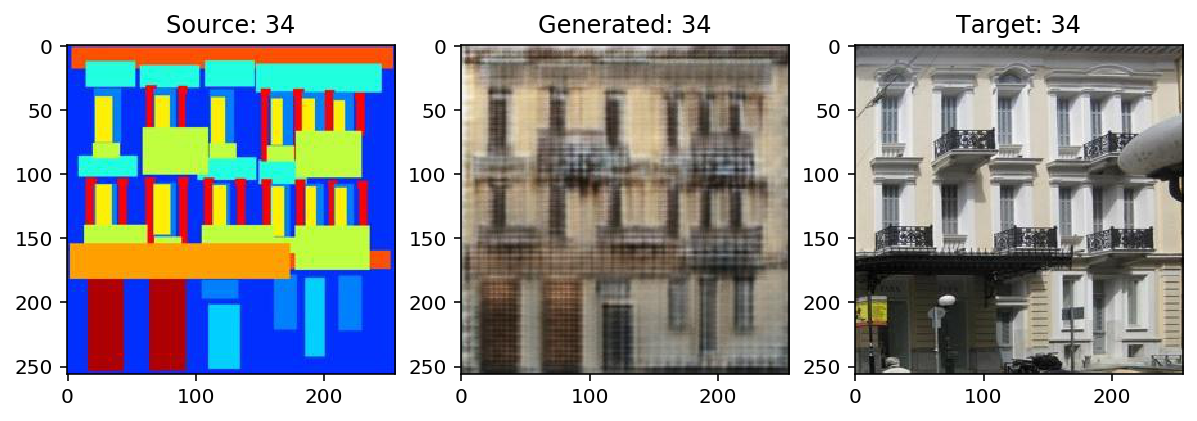

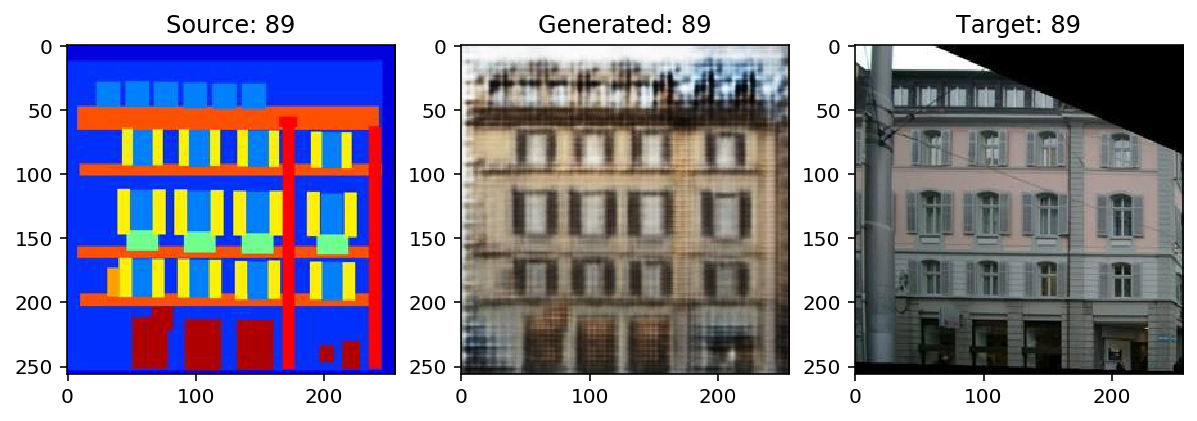

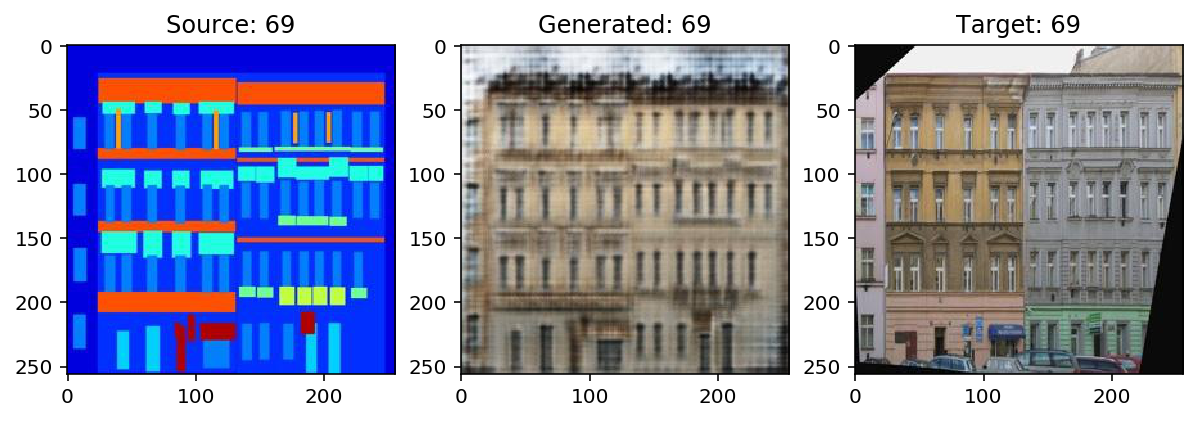

In [11]:
from utils import *
path_to_images = '/mnt/nfs/data/pix2pix_outputs'
display_results(path_to_images, display_max_examples=3)

If you don't want to wait 200 epochs for the training (~1h30 with a Nvidia P100 GPU), you can execute the code below and generate images with a provided pre-trained model.


----------------


## Use a Pix2Pix pre-trained model  to generate result images 

In this last example, you will create a single stage pipeline and use a provided pre-trained model to generate result images for the test dataset.

In [12]:
from nested_test_pix2pix import *

# -------------------------------------
#  Using the Kueflow SDK, build the 
#     pipeline component/ops for 
#  the "Test Pix2Pix" tasks by 
#   directly converting its 
#  Python function into a KFP ops 
# -------------------------------------
test_op = comp.func_to_container_op(test_pix2pix,
                                    base_image='gcr.io/{}/kubeflow_gpu_template:latest'.format(GCP_PROJECT_ID), )


# ------------------------------------- 
#  Define the pix2pix single stage
#         Pipeline Function
# -------------------------------------
@dsl.pipeline(
    name='Pix2Pix Generator',
    description='A single stage pipeline using a pre-trained model to generate result images for the test dataset'
)

def pix2pix(
    pathmodel = dsl.PipelineParam('pathmodel', value=PRETRAINED_MODEL),  # Notice how we use a pre-trained model this time
    pathoutput = dsl.PipelineParam('pathoutput', value=PIX2PIX_OUTPUTS)
):
    


    test_task = test_op(pathdataset='/mnt/nfs/data/datasets/facades/test.tfrecords', 
                        pathoutput=pathoutput,
                        pathmodel=pathmodel) \
                                .add_volume(k8s_client.V1Volume(name='workdir', 
                                                                persistent_volume_claim=k8s_client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs'))) \
                                .add_volume_mount(k8s_client.V1VolumeMount(mount_path=NFS_MOUNT, name='workdir'))
    
    # Execute the testing task on a GPU node
    test_task.set_gpu_limit(1)
    

# -------------------------------------
#       Compile the Pipeline 
# -------------------------------------    
pipeline_filename = pix2pix.__name__ + '.pipeline.tar.gz'
compiler.Compiler().compile(pipeline_func=pix2pix, 
                            package_path=pipeline_filename)

# ------------------------------------- 
#           Create (or reuse) a    
#      Kubeflow Pipeline Experiment
# -------------------------------------
EXPERIMENT_NAME = "KFP Pix2Pix Inference"   ## Customize Name
client = kfp.Client()

try:
    experiment = client.get_experiment(experiment_name=EXPERIMENT_NAME)
except:
    experiment = client.create_experiment(EXPERIMENT_NAME)


run_name = pix2pix.__name__ + ' run'
run_result = client.run_pipeline(experiment.id, run_name, pipeline_filename)


#### Display the results using the test dataset

Once the Pipeline execution is finished, you can display some results.

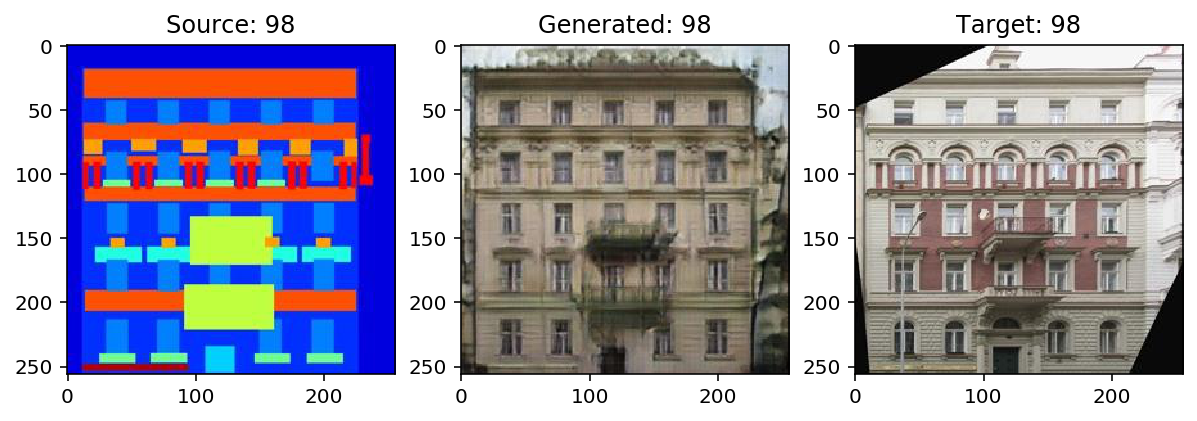

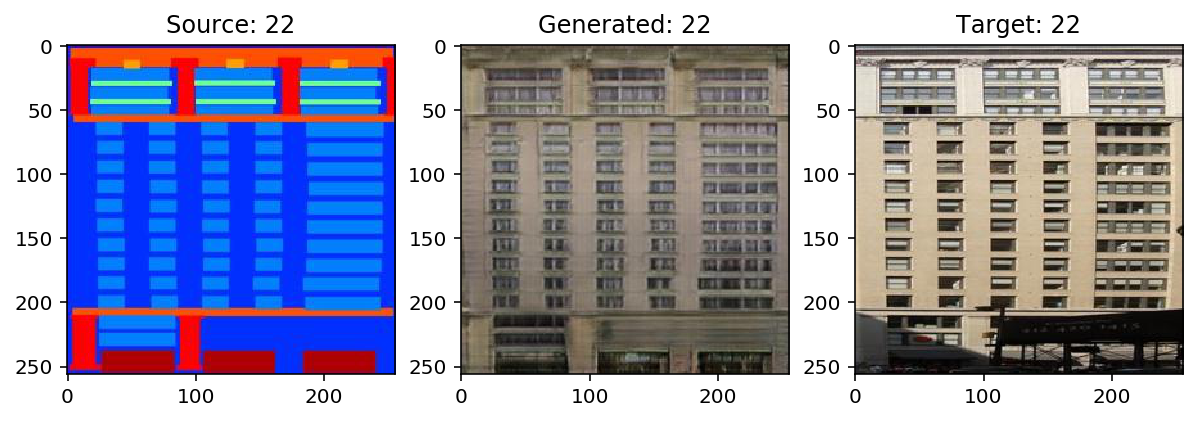

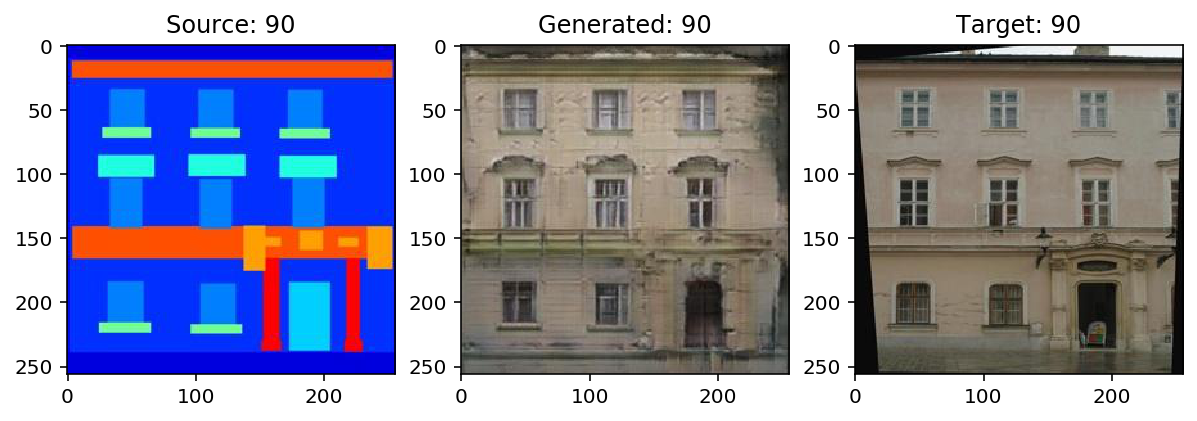

In [13]:
from utils import *
path_to_images = '/mnt/nfs/data/pix2pix_outputs'
display_results(path_to_images, display_max_examples=3)

#### Cleaning

(Code disabled)

```
%%bash -s "$GCP_PROJECT_ID"

#rm -rf /mnt/nfs/data/datasets/*
rm -rf /mnt/nfs/data/pretrained_model/*
rm -rf /mnt/nfs/data/models/*
rm -rf /mnt/nfs/data/logs/*
rm -rf /mnt/nfs/data/pix2pix_outputs/*
rm -f ./Dockerfile
rm -f ./*.tar.gz
rm -f ./nested_*.log
rm -rf ./datasets
gsutil rm -rf "gs://$1/tensorboard/*"

ls -l /mnt/nfs/data/*
gsutil ls -l "gs://$1/"

# Don't forget to manually clean the gcloud builds in your Google Storage.

``` 